# Lab04 Task 1: Unstructured Pruning

In this notebook, you will learn how to apply unstructured pruning in order to reduce the complexity of a neural network model. A pre-trained model will be used as the basis for performing unstructured pruning and subsequent fine-tuning.

<font color="red">**Only add or modify code between `YOUR CODE START` and `YOUR CODE END`. Don’t change anything outside of these markers.**</font>

In [1]:
##### YOUR CODE START #####

# Please fill in your student id here.
student_id = "314580042"

##### YOUR CODE END #####

### Library Import

The libraries you need for this practice are listed below. You can add more if you think they’re necessary. If you’re not sure whether a library is allowed, ask TA in the FB group.

In [2]:
import os
import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import datasets, transforms, models
import torch.nn.utils.prune as prune
import matplotlib
import matplotlib.pyplot as plt

##### YOUR CODE START #####

# Do you need any additional libraries? If not, you can leave this block empty.

##### YOUR CODE END #####

### Device
If you have GPU available, you should see "cuda" in the following cell.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: %s" % device)

Using device: cuda


### Dataset

In this lab, we will use CIFAR-10 dataset. CIFAR-10 is a widely used image classification dataset consisting of 60,000 color images at 32×32 resolution. It has 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck), with 50,000 training images and 10,000 test images. Due to its small size and balanced categories, CIFAR-10 is commonly used for benchmarking machine learning and computer vision models.

CIFAR-10 has both a training set and a test set. You may further split the training set to create a validation set, but <font color="red">**it is strictly forbidden to use any images in test set for model training.**</font>

In [4]:
# Load test set

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

In [5]:
# Load train set

##### YOUR CODE START #####

# Load the training set here.
# You can follow the same method as loading the test set above, or additionally split a validation set from the training set, or add transforms (such as flipping images), etc.

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

##### YOUR CODE END #####

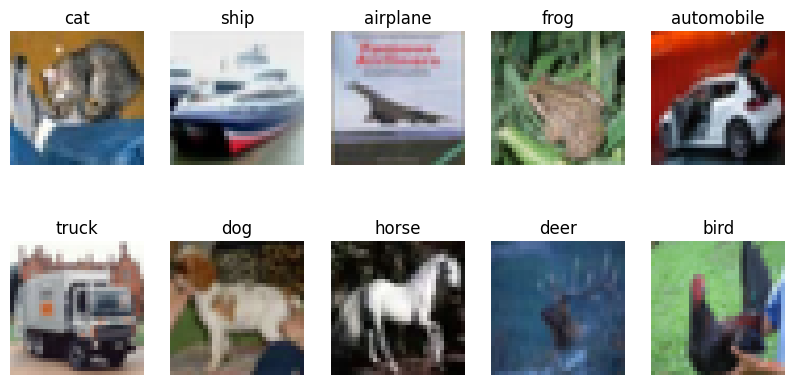

In [6]:
# Let's see some image samples in CIFAR-10 dataset.

def show_img():
    classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']
    seen = set()
    images = []
    labels = []
    for img, label in testset:
        if label not in seen:
            seen.add(label)
            images.append(img)
            labels.append(classes[label])
        if len(seen) == len(classes):
            break
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        img = images[i] * std.view(3,1,1) + mean.view(3,1,1)
        img = img.clamp(0, 1)
        img = img.permute(1, 2, 0)
        ax.imshow(img.cpu().numpy())
        ax.set_title(labels[i])
        ax.axis("off")
    plt.show()

show_img()

### Load Model
In this lab, you do not need to train a model from scratch. We will use a pretrained ResNet20 model instead. ResNet is a popular deep learning model for image classification. Its key feature is the use of skip (residual) connections, which make training deep networks easier and more stable.
The code below loads the pre-trained model and evaluates its accuracy on the test set, which should be <font color="red">**92.60%**</font>. Please use this model for the subsequent pruning tasks. <font color="red">**Designing and training your own model is not allowed.**</font>

In [7]:
model = torch.hub.load('chenyaofo/pytorch-cifar-models', 
                       'cifar10_resnet20', pretrained=True).to(device)
model.eval()

Using cache found in /export/home/dl2025f/dl2025f_116/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [8]:
def test_acc():
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Accuracy on CIFAR-10 test set: {acc:.2f}%')
    return acc
    
_ = test_acc()

Accuracy on CIFAR-10 test set: 92.59%


### Sparsity

The function below prints the sparsity of the model, which refers to the proportion of zero-valued parameters in each layer. Since we haven’t pruned the model, the sparsity should be 0% for every layer.

In [9]:
def print_sparsity(model, detail=False):
    zeros_all = 0
    total_all = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weight = module.weight
            zeros = float(torch.sum(weight == 0))
            total = float(weight.nelement())
            zeros_all += zeros
            total_all += total
            sparsity = 100.0 * zeros / total
            if detail:
                print(f"Layer {name}: Sparsity = {sparsity:.2f}% ({int(zeros)}/{int(total)})")
    sparsity = 100.0 * zeros_all / total_all
    print(f"Overall Sparsity = {sparsity:.2f}% ({int(zeros_all)}/{int(total_all)})")
    return sparsity

sparsity = print_sparsity(model, detail=True)

Layer conv1: Sparsity = 0.00% (0/432)
Layer layer1.0.conv1: Sparsity = 0.00% (0/2304)
Layer layer1.0.conv2: Sparsity = 0.00% (0/2304)
Layer layer1.1.conv1: Sparsity = 0.00% (0/2304)
Layer layer1.1.conv2: Sparsity = 0.00% (0/2304)
Layer layer1.2.conv1: Sparsity = 0.00% (0/2304)
Layer layer1.2.conv2: Sparsity = 0.00% (0/2304)
Layer layer2.0.conv1: Sparsity = 0.00% (0/4608)
Layer layer2.0.conv2: Sparsity = 0.00% (0/9216)
Layer layer2.0.downsample.0: Sparsity = 0.00% (0/512)
Layer layer2.1.conv1: Sparsity = 0.00% (0/9216)
Layer layer2.1.conv2: Sparsity = 0.00% (0/9216)
Layer layer2.2.conv1: Sparsity = 0.00% (0/9216)
Layer layer2.2.conv2: Sparsity = 0.00% (0/9216)
Layer layer3.0.conv1: Sparsity = 0.00% (0/18432)
Layer layer3.0.conv2: Sparsity = 0.00% (0/36864)
Layer layer3.0.downsample.0: Sparsity = 0.00% (0/2048)
Layer layer3.1.conv1: Sparsity = 0.00% (0/36864)
Layer layer3.1.conv2: Sparsity = 0.00% (0/36864)
Layer layer3.2.conv1: Sparsity = 0.00% (0/36864)
Layer layer3.2.conv2: Sparsity =

### Pruning & Fine-Tune

Finally, you can prune and fine-tune the model. In this lab, you should achieve <font color="red">**>50% sparsity**</font> while keeping <font color="red">**test accuracy >90%**</font>. An example that prunes 50% of the weights in each layer is provided below. Feel free to push the sparsity higher to earn a better score!

In [10]:
##### YOUR CODE START #####

def train_with_schedule(model, trainloader, optimizer, num_epochs):
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    for epoch in range(num_epochs):
        model.train()
        for images, labels in trainloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}")

# Criterion
criterion = nn.CrossEntropyLoss()

# Collect parameters (excluding conv1 and fc initially)
parameters_to_prune = []
for name, module in model.named_modules():
    if name == 'conv1' or name == 'fc':
        continue  # Will handle these separately
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        parameters_to_prune.append((module, 'weight'))

print(f"Layers for global pruning: {len(parameters_to_prune)}")

# Pruning schedule: smaller increments, especially at high sparsity
sparsity_schedule = [
    # (target, epochs, lr, prune_first_last)
    (0.30, 10, 0.01, True),   # 30%: 10 epochs, lr=0.01, light prune first/last
    (0.50, 10, 0.01, True),   # 50%: 10 epochs, lr=0.01, light prune first/last
    (0.60, 15, 0.01, False),  # 60%: 15 epochs, lr=0.01, skip first/last
    (0.65, 20, 0.001, False), # 65%: 20 epochs, lr=0.001, skip first/last
    (0.70, 20, 0.001, False), # 70%: 20 epochs, lr=0.001, skip first/last
    (0.75, 25, 0.001, False), # 75%: 25 epochs, lr=0.001, skip first/last
    (0.80, 30, 0.001, False), # 80%: 30 epochs, lr=0.001, skip first/last
    (0.85, 30, 0.001, False), # 85%: 30 epochs, lr=0.001, skip first/last
    (0.86, 30, 0.001, False), # 86%: 30 epochs, lr=0.001, skip first/last
    (0.87, 30, 0.001, False), # 87%: 30 epochs, lr=0.001, skip first/last
    (0.88, 30, 0.001, False), # 88%: 30 epochs, lr=0.001, skip first/last
    (0.89, 30, 0.001, False), # 89%: 30 epochs, lr=0.001, skip first/last
    (0.90, 30, 0.001, False), # 90%: 30 epochs, lr=0.001, skip first/last
    (0.91, 30, 0.001, False), # 91%: 30 epochs, lr=0.001, skip first/last
    (0.92, 30, 0.001, False), # 92%: 30 epochs, lr=0.001, skip first/last
]

best_model_state = None
best_accuracy = 0
best_sparsity = 0

# Keep same optimizer across rounds for momentum benefits
optimizer = None

for target_sparsity, num_epochs, lr, prune_first_last in sparsity_schedule:
    print(f"\n{'='*70}")
    print(f"Target: {target_sparsity*100:.0f}% sparsity | Epochs: {num_epochs} | LR: {lr}")
    print(f"{'='*70}")
    
    # Apply global pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=target_sparsity,
    )
    
    # Handle first/last layers
    if prune_first_last and target_sparsity <= 0.5:
        # Only prune lightly in early rounds
        light_amount = target_sparsity * 0.3  # 30% of target
        prune.l1_unstructured(model.conv1, name="weight", amount=light_amount)
        prune.l1_unstructured(model.fc, name="weight", amount=light_amount)
        print(f"Lightly pruned conv1/fc at {light_amount*100:.0f}% sparsity")
    else:
        print("Skipping conv1/fc pruning (protecting critical layers)")
    
    # Create/update optimizer with appropriate LR
    if optimizer is None or lr != optimizer.param_groups[0]['lr']:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        print(f"Created optimizer with LR={lr}")
    
    # Fine-tune
    print(f"Fine-tuning for {num_epochs} epochs...")
    train_with_schedule(model, trainloader, optimizer, num_epochs)
    
    # Remove masks to make pruning permanent before next round
    for module, param_name in parameters_to_prune:
        if hasattr(module, f"{param_name}_mask"):
            prune.remove(module, param_name)
    if prune_first_last and target_sparsity <= 0.5:
        if hasattr(model.conv1, "weight_mask"):
            prune.remove(model.conv1, "weight")
        if hasattr(model.fc, "weight_mask"):
            prune.remove(model.fc, "weight")
    
    # Evaluate
    model.eval()
    current_acc = test_acc()
    current_sparsity = print_sparsity(model, detail=False)
    
    print(f"\n>>> Accuracy: {current_acc:.2f}% | Sparsity: {current_sparsity:.2f}% <<<")
    
    # Save if good
    if current_acc >= 90.0:
        print(f"✓ Accuracy >= 90%, saving checkpoint...")
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        best_accuracy = current_acc
        best_sparsity = current_sparsity
    else:
        print(f"✗ Accuracy < 90%, stopping and reverting to best model.")
        print(f"   Best was: Acc={best_accuracy:.2f}%, Sparsity={best_sparsity:.2f}%")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model.to(device)
    print(f"\n{'='*70}")
    print(f"FINAL: Accuracy={best_accuracy:.2f}% | Sparsity={best_sparsity:.2f}%")
    print(f"{'='*70}")
else:
    print("\nWARNING: No model achieved 90% accuracy!")

model.eval()
        
##### YOUR CODE END #####

Layers for global pruning: 20

Target: 30% sparsity | Epochs: 10 | LR: 0.01
Lightly pruned conv1/fc at 9% sparsity
Created optimizer with LR=0.01
Fine-tuning for 10 epochs...
  Epoch 5/10, LR: 0.005000
  Epoch 10/10, LR: 0.000000
Accuracy on CIFAR-10 test set: 92.74%
Overall Sparsity = 29.92% (81044/270896)

>>> Accuracy: 92.74% | Sparsity: 29.92% <<<
✓ Accuracy >= 90%, saving checkpoint...

Target: 50% sparsity | Epochs: 10 | LR: 0.01
Lightly pruned conv1/fc at 15% sparsity
Created optimizer with LR=0.01
Fine-tuning for 10 epochs...
  Epoch 5/10, LR: 0.005000
  Epoch 10/10, LR: 0.000000
Accuracy on CIFAR-10 test set: 92.45%
Overall Sparsity = 49.86% (135073/270896)

>>> Accuracy: 92.45% | Sparsity: 49.86% <<<
✓ Accuracy >= 90%, saving checkpoint...

Target: 60% sparsity | Epochs: 15 | LR: 0.01
Skipping conv1/fc pruning (protecting critical layers)
Created optimizer with LR=0.01
Fine-tuning for 15 epochs...
  Epoch 5/15, LR: 0.007500
  Epoch 10/15, LR: 0.002500
  Epoch 15/15, LR: 0.000

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [11]:
# Let's see the result.
acc = test_acc()
sparsity = print_sparsity(model)

print("\n===========================================\n")

if acc < 90.0:
    print("Oh no! Your test accuracy is too low!")
if sparsity < 50.0:
    print("Oh no! Your sparsity is too low!")
if acc >= 90.0 and sparsity >= 50.0:
    print("Congratulations! You've achieved the goals of this task. Remember to save your model!")
    print("You can also try increasing sparsity further to earn a higher score!")

Accuracy on CIFAR-10 test set: 90.50%
Overall Sparsity = 91.66% (248292/270896)


Congratulations! You've achieved the goals of this task. Remember to save your model!
You can also try increasing sparsity further to earn a higher score!


### Save Model

You can use the code below to save your model as `model_[student_id].pt`, where `[student_id]` is replaced by your student ID in the first cell of this notebook.

In [12]:
# Remove mask generated by torch.nn.utils.prune before saving, otherwise TA wouldn't be able to laod your model.
for module in model.modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        if prune.is_pruned(module):
            prune.remove(module, 'weight')
file_name = student_id + "_pruning.pt"
# Save model.state_dict() instead of the entire model.
torch.save(model.state_dict(), file_name)
print("Your model is saved to \"" + file_name + "\".")

Your model is saved to "314580042_pruning.pt".


### Final Check

TA has provided check_pruning.py for students to check if their models can pass the tests. <font color="red">**Please make sure to check it before submission.**</font>

In [13]:
!python check_pruning.py --path {file_name}

Congratulations! You've achieved the goals of this task.
Your model's sparsity is 91.66%.
